# Ian Timeseries

In [3]:
import os
import pickle
from typing import List, Tuple, Optional

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy

from src import configure, plotting, utilities

In [4]:
config = configure.get_config()
configure.configure_ipython()
plotting.configure_figures()

## Datasets

### Drifters

In [5]:
def read_drifter_dataset(path: str) -> pd.DataFrame:
    with open(path, 'rb') as handle:
        drifter_data = pickle.load(handle)

    # Concatenate the individual drifter DataFrames by type
    microswift_df = concatenate_drifters(drifter_data['microswift'])
    spotter_df = concatenate_drifters(drifter_data['spotter'])
    dwsd_df = concatenate_drifters(drifter_data['dwsd'])

    # Create a drifter type column
    microswift_df['drifter_type'] = 'microswift'
    spotter_df['drifter_type'] = 'spotter'
    dwsd_df['drifter_type'] = 'dwsd'

    # Combine all drifters into a single DataFrame.
    drifter_df = (pd.concat([microswift_df, spotter_df, dwsd_df])
                .sort_index(level=['id', 'time'], ascending=True))
    # .loc[(slice(None), time_slice), :]
    return drifter_df


def concatenate_drifters(drifter_dict: dict) -> pd.DataFrame:
    """
    Concatenate a dictionary of individual drifter DataFrames into a single,
    multi-index DataFrame.  Drop the observations that do not contain waves
    (remove off-hour pressure and temperature observations).

    Args:
        drifter_dict (dict): individual drifter DataFrames keyed by id.

    Returns:
        DataFrame: concatenated drifters
    """
    drifter_df = (
        pd.concat(drifter_dict, names=['id', 'time'])
        .dropna(subset='energy_density')
    )
    return drifter_df

In [6]:
ian_drifter_df = read_drifter_dataset(config['dir']['ian_drifter_data'])

In [88]:
spotter_id = 'SPOT-30068D'
spotter_df = ian_drifter_df.loc[spotter_id]

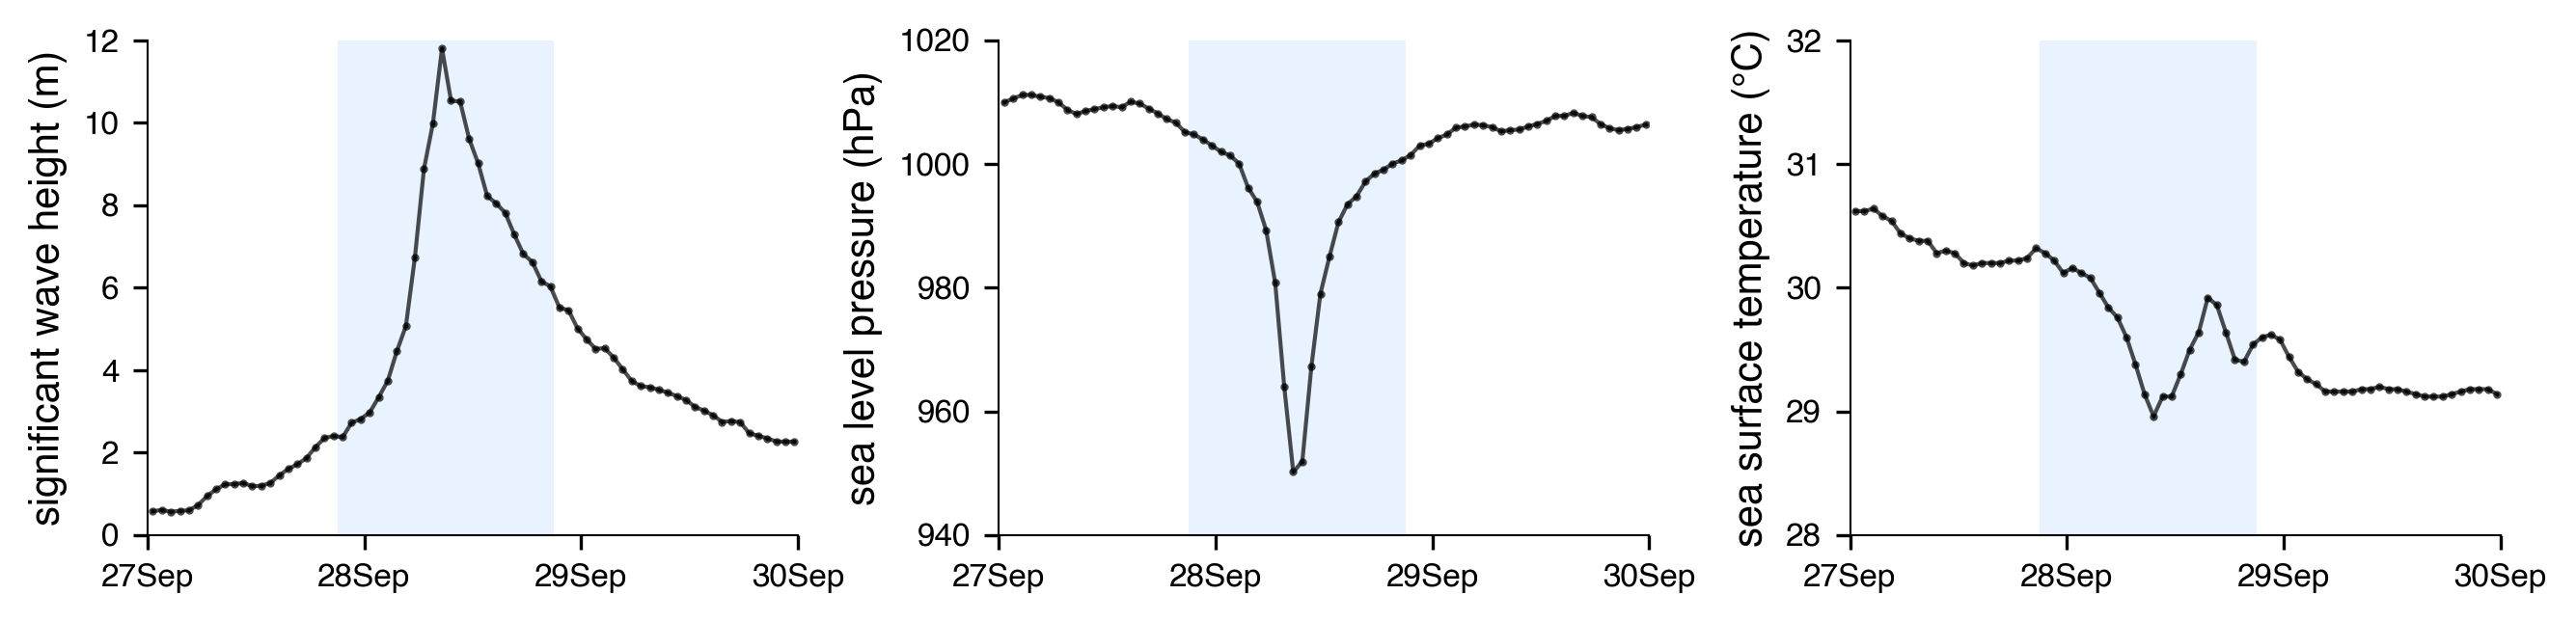

In [108]:
plot_kwargs = dict(
    linewidth=1.0,
    marker='.',
    markersize=2,
    alpha=0.7,
    color='k',
)
fill_between_kwargs = dict(
    color = 'dodgerblue',
    alpha = 0.1,
    edgecolor = 'none',
)

# This should match maps.ipynb
hour_to_display = pd.Timestamp('2022-09-28T09:00', tz='UTC')
time_slice = slice(hour_to_display - pd.Timedelta('12h'),
                   hour_to_display + pd.Timedelta('12h'))

fig, axes = plt.subplots(1, 3, figsize=(9, 2.25), sharex=True)
axes[0].plot(
    spotter_df.index.get_level_values('time'),
    spotter_df['significant_height'],
    **plot_kwargs,
)
axes[0].set_ylabel('significant wave height (m)')
axes[0].set_ylim([0, 12])

axes[1].plot(
    spotter_df.index.get_level_values('time'),
    spotter_df['sea_level_pressure'],
    **plot_kwargs,
)
axes[1].set_ylabel('sea level pressure (hPa)')
axes[1].set_ylim([940, 1020])

axes[2].plot(
    spotter_df.index.get_level_values('time'),
    spotter_df['sea_surface_temperature'],
    **plot_kwargs,
)
axes[2].set_ylabel('sea surface temperature (°C)')
axes[2].set_ylim([28, 32])

for ax in axes:
    # Fill b/t time highlight.
    ylims = ax.get_ylim()
    ax.fill_between(
        [time_slice.start, time_slice.stop],
        ylims[0], ylims[1],
        **fill_between_kwargs,
    )

    # Remove top and right spines (less clutter).
    plotting.remove_top_and_right_spines(ax)

plotting.set_time_series_xaxis(
    axes[0],
    # plot_time_start=spotter_df.index.get_level_values('time').min(),
    # plot_time_end=spotter_df.index.get_level_values('time').max(),
    plot_time_start=pd.Timestamp('2022-09-27T00:00', tz='UTC'),
    plot_time_end=pd.Timestamp('2022-09-30T00:00', tz='UTC'),
    freq='24h',
    format='%d%b'
    # format='%b%d'
)
fig.tight_layout(w_pad=0.00)
fig.savefig(f'hurricane_ian_time_series_{spotter_id}.jpg', dpi=500)
fig.savefig(f'hurricane_ian_time_series_{spotter_id}.png')